In [1]:
import numpy as np
import codecs
import pickle
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Lambda, Flatten, Input, MaxPooling2D, Convolution2D,Conv2D,Activation,BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from scipy import misc
import os
from os.path import isfile, join
import itertools
import random
import keras
from keras.constraints import maxnorm
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import SGD,Adam
from keras.applications import VGG16
from keras.layers.merge import concatenate
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Image
import PIL
import glob
from scipy.misc import imresize, imread
from scipy.spatial.distance import pdist, squareform, cdist
import cv2

Using TensorFlow backend.


In [2]:
np.random.seed(7)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
TRAIN_DIR='data/TRAIN'
TEST_DIR='data/TEST'

In [3]:
'''
Created on Jul 10, 2016

@author: ssudholt
'''
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist

def map_from_feature_matrix(features, labels, metric, drop_first):
    '''
    Computes mAP and APs from a given matrix of feature vectors
    Each sample is used as a query once and all the other samples are
    used for testing. The user can specify whether he wants to include
    the query in the test results as well or not.
    
    Args:
        features (2d-ndarray): the feature representation from which to compute the mAP
        labels (1d-ndarray or list): the labels corresponding to the features (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # argument error checks
    if features.shape[0] != len(labels):
        raise ValueError('The number of feature vectors and number of labels must match')
    # compute the pairwise distances from the
    # features
    dists = pdist(X=features, metric=metric)
    dists = squareform(dists)
    inds = np.argsort(dists, axis=1)
    retr_mat = np.tile(labels, (features.shape[0],1))
    
    # compute two matrices for selecting rows and columns
    # from the label matrix
    # -> advanced indexing
    row_selector = np.transpose(np.tile(np.arange(features.shape[0]), (features.shape[0],1)))
    retr_mat = retr_mat[row_selector, inds]
    
    # create the relevance matrix
    rel_matrix = retr_mat == np.atleast_2d(labels).T
    if drop_first:
        rel_matrix = rel_matrix[:,1:]
        
    # calculate mAP and APs
    map_calc = MeanAveragePrecision()
    avg_precs = np.array([map_calc.average_precision(row) for row in rel_matrix])
    mAP = np.mean(avg_precs)
    return mAP, avg_precs

def map_from_query_test_feature_matrices(query_features, test_features, query_labels, test_labels, 
                                         metric, drop_first=False):
    '''
    Computes mAP and APs for a given matrix of query representations
    and another matrix of test representations
    Each query is used once to rank the test samples.
    
    Args:
        query_features (2d-ndarray): the feature representation for the queries
        query_labels (1d-ndarray or list): the labels corresponding to the queries (either numeric or characters)
        test_features (2d-ndarray): the feature representation for the test samples
        test_labels (1d-ndarray or list): the labels corresponding to the test samples (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # some argument error checking
    if query_features.shape[1] != test_features.shape[1]:
        raise ValueError('Shape mismatch')
    if query_features.shape[0] != len(query_labels):
        raise ValueError('The number of query feature vectors and query labels does not match')
    if test_features.shape[0] != len(test_labels):
        raise ValueError('The number of test feature vectors and test labels does not match')
    
    # compute the nearest neighbors
    dist_mat = cdist(XA=query_features, XB=test_features, metric=metric)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    
    # create the retrieval matrix
    retr_mat = np.tile(test_labels, (len(query_labels),1))
    row_selector = np.transpose(np.tile(np.arange(len(query_labels)), (len(test_labels),1)))
    retr_mat = retr_mat[row_selector, retrieval_indices]
    
    # create the relevance matrix
    relevance_matrix = retr_mat == np.atleast_2d(query_labels).T
    if drop_first:
        relevance_matrix = relevance_matrix[:,1:]
    
    # calculate mAP and APs
    mapCalc = MeanAveragePrecision()
    avg_precs = np.array([mapCalc.average_precision(row) for row in relevance_matrix], ndmin=2).flatten()
    mAP = np.mean(avg_precs)    
    return mAP, avg_precs

class IterativeMean(object):
    '''
    Class for iteratively computing a mean. With every new value (@see: _add_value)
    the mean will be updated 
    '''
    
    def __init__(self, mean_init=0.0):
        self.__mean = mean_init
        self.__N = 0.0
        
    def add_value(self, value):
        '''
        Updates the mean with respect to value
        
        Args:
            value (float): The value that will be incorporated in the mean
        '''  
        self.__mean = (self.__N / (self.__N + 1)) * self.__mean + (1.0 / (self.__N + 1)) * value
        self.__N += 1
        
    def get_mean(self):
        return self.__mean
    
    def reset(self):
        self.__mean = 0.0
        self.__N = 0.0
         

class MeanAveragePrecision(IterativeMean):
    '''
    Computes average precision values and iteratively updates their mean
    '''
    def __init__(self):
        super(MeanAveragePrecision, self).__init__()        
        
    def average_precision(self, ret_vec_relevance, gt_relevance_num=None):
        '''
        Computes the average precision and updates the mean average precision
        
        Args:
            ret_vec_relevance (1d-ndarray): array containing ground truth (gt) relevance values
            gt_relevance_num (int): The number of relevant samples in retrieval. If None the sum
                                    over the retrieval gt list is used.
        '''
        ret_vec_cumsum = np.cumsum(ret_vec_relevance, dtype=float)
        ret_vec_range = np.arange(1, ret_vec_relevance.size + 1)
        ret_vec_precision = ret_vec_cumsum / ret_vec_range
        
        if gt_relevance_num is None:
            n_relevance = ret_vec_relevance.sum()
        else:
            n_relevance = gt_relevance_num

        if n_relevance > 0:
            ret_vec_ap = (ret_vec_precision * ret_vec_relevance).sum() / n_relevance
        else:
            ret_vec_ap = 0.0
        
        super(MeanAveragePrecision, self).add_value(ret_vec_ap)
        
        return ret_vec_ap

In [4]:
def n_image_pair_names_from_folder(foldername,shuffle,ratio,number_of_same_pairs):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        list_same_pairs=list(same_pairs_it)
        random.shuffle(list_same_pairs)
        n_same_pairs=list_same_pairs[:number_of_same_pairs]
        # for each same pair, a different pair
        for ref_image, same_image in n_same_pairs:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                while True:
                    j = np.random.randint(low=0, high=len(class_list), size=1)[0]
                    if j != i: break
                dif_image_candidates = image_classes[class_list[j]]
                k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
                dif_image = dif_image_candidates[k]
                image_pairs.append((ref_image, dif_image, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

In [5]:
def image_pair_names_from_folder(foldername,shuffle,ratio):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        # for each same pair, a different pair
        for ref_image, same_image in same_pairs_it:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                while True:
                    j = np.random.randint(low=0, high=len(class_list), size=1)[0]
                    if j != i: break
                dif_image_candidates = image_classes[class_list[j]]
                k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
                dif_image = dif_image_candidates[k]
                image_pairs.append((ref_image, dif_image, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

In [6]:
train_pair_names=n_image_pair_names_from_folder(TRAIN_DIR,True,1,100)
number_of_train_pairs=len(train_pair_names)
print("Some sample train pair names: ", train_pair_names[:5])
print('number of train pairs: ', number_of_train_pairs)

Some sample train pair names:  [('361_11.png', '361_12.png', 1), ('329_3.png', '329_7.png', 1), ('2695_1.png', '1498_1.png', 0), ('498_1.png', '498_5.png', 1), ('405_7.png', '405_1.png', 1)]
number of train pairs:  69344


In [7]:
def select_hard_negatives(features, labels):
    dists = pdist(X=features, metric='cosine')
    dists = squareform(dists)
    inds = np.argsort(dists, axis=1)
    retr_mat = np.tile(labels, (features.shape[0],1))
    row_selector = np.transpose(np.tile(np.arange(features.shape[0]), (features.shape[0],1)))
    retr_mat = retr_mat[row_selector, inds]
    rel_matrix = retr_mat == np.atleast_2d(labels).T
      
    hard_negatives=[]
    for row in range(rel_matrix.shape[0]):
        rel_row=rel_matrix[row]
        last_true_index=np.where(rel_row==True)[0][-1]
        rel_indices=rel_row[:last_true_index]
        false_indices=(np.where(rel_indices==False)[0]).tolist()
        for index in (false_indices):
            hard_negatives.append((labels[row],labels[index]))
    
    shn=set(hard_negatives)
    rshn=set([(item[1],item[0]) for item in shn ])
    result=list(shn.intersection(rshn))
    return result

In [8]:
def image_pair_names_from_hard_negatives(foldername,hard_list,shuffle,ratio):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        # for each same pair, a different pair
        for ref_image, same_image in same_pairs_it:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                j = np.random.randint(low=0, high=len(hard_list), size=1)[0]
                dif_image_candidates1 = image_classes[str(hard_list[j][0])]
                k1 = np.random.randint(low=0, high=len(dif_image_candidates1), size=1)[0]
                dif_image1 = dif_image_candidates1[k1]
                dif_image_candidates2 = image_classes[str(hard_list[j][1])]
                k2 = np.random.randint(low=0, high=len(dif_image_candidates2), size=1)[0]
                dif_image2 = dif_image_candidates2[k2]
                image_pairs.append((dif_image1, dif_image2, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

In [9]:
def n_image_pair_names_from_hard_negatives(foldername,hard_list,shuffle,ratio):
    image_classes = {}
    for image_name in os.listdir(foldername):
        class_name = image_name[0:-4].split('_')[0]
        if class_name in image_classes:
            image_classes[class_name].append(image_name)
        else:
            image_classes[class_name] = [image_name]
    image_pairs = []
    class_list = sorted(list(image_classes.keys()))
    for i, c in enumerate(class_list):
        images_in_class = image_classes[c]
        # same pairs
        same_pairs_it = itertools.permutations(images_in_class, 2)
        # for each same pair, a different pair
        for ref_image, same_image in same_pairs_it:
            image_pairs.append((ref_image, same_image, 1))
            for r in range(ratio):
                j = np.random.randint(low=0, high=len(hard_list), size=1)[0]
                dif_image_candidates1 = image_classes[str(hard_list[j][0])]
                k1 = np.random.randint(low=0, high=len(dif_image_candidates1), size=1)[0]
                dif_image1 = dif_image_candidates1[k1]
                dif_image_candidates2 = image_classes[str(hard_list[j][1])]
                k2 = np.random.randint(low=0, high=len(dif_image_candidates2), size=1)[0]
                dif_image2 = dif_image_candidates2[k2]
                image_pairs.append((dif_image1, dif_image2, 0))
    if(shuffle):
        random.shuffle(image_pairs)
    return image_pairs

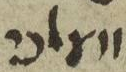

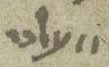

In [10]:
pair1 = Image(TRAIN_DIR+'/252_2.png')
pair2 = Image(TRAIN_DIR+'/252_1.png')
display(pair1,pair2)

In [11]:
def get_input(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (90, 40))
    img = img.astype('float32')
    img = img / 255. 
    img = img.reshape(img.shape + (1,))
    return (img)

In [12]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return [X[:, 0], X[:, 1]], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim,)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            image1=get_input(TRAIN_DIR+'/'+ID[0])
            image2=get_input(TRAIN_DIR+'/'+ID[1])
            X += [[image1, image2]]

            # Store class
            y.append(ID[2])
            aX=np.array(X)
            ay=np.array(y)

        return aX,ay


In [13]:
def load_test_data(foldername):
    images=[]
    labels=[]
    for image_name in os.listdir(foldername):
        label = int(image_name[0:-4].split('_')[0])
        labels.append(label)
        image=get_input(foldername+'/'+image_name)
        images.append(image)
    return np.array(images), np.array(labels)

In [14]:
def show_array(a):
    plt.imshow(a, cmap=plt.get_cmap('gray'))
    plt.show()

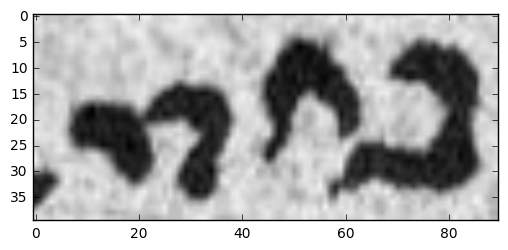

In [15]:
x_test, y_test=load_test_data(TEST_DIR)
show_array(np.squeeze(x_test[0]))

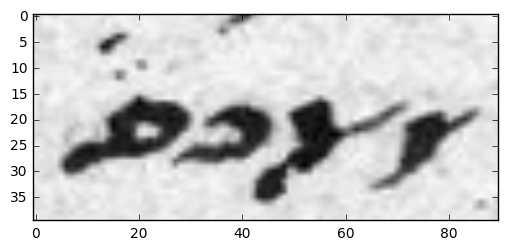

In [16]:
x_train, y_train=load_test_data(TRAIN_DIR)
show_array(np.squeeze(x_train[0]))

In [17]:
def create_base_network(input_dim):
    model=Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_dim, activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))


    return model

In [18]:
class custom_call(Callback):
    def __init__(self):
        self.patient=0
        self.best_map=0
    def on_epoch_end(self, epoch, logs={}):
        if self.patient>=15:
            print('patient= ', self.patient)
            self.model.stop_training = True
        feat_extractor = Model(inputs=self.model.layers[2].get_input_at(0), outputs=self.model.layers[2].layers[19].output)
        features=feat_extractor.predict(x_test)
        current_map=map_from_feature_matrix(features, y_test, 'cosine', True)[0]
        print(' map:',current_map)
        if current_map>=self.best_map:
            self.patient=0
            self.best_map=current_map
            print('best map=',self.best_map)
            print('patient=',self.patient)
            for f in glob.glob("hard_pairs_best_model*"):
                os.remove(f)
            self.model.save('hard_pairs_best_model_'+str(self.best_map)[:5])
        else:
            self.patient=self.patient+1
            print('current map=',current_map)
            print('best map=',self.best_map)
            print('patient=',self.patient)
    def on_batch_end(self,batch,logs={}):
        if batch%500==0:
            feat_extractor = Model(inputs=self.model.layers[2].get_input_at(0), outputs=self.model.layers[2].layers[19].output)
            features=feat_extractor.predict(x_test)
            test_map=map_from_feature_matrix(features, y_test, 'cosine', True)[0]
            print('test map:',test_map)
            

In [19]:
print_map=custom_call()
training_generator = DataGenerator(train_pair_names, batch_size=16, shuffle=True)

In [20]:
def abs_diff_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1


def get_abs_diff(vects):
    x, y = vects
    return K.abs(x - y)

model=load_model('random_pairs_best_model_0.587')

'''
input_dim = (40,90,1)
base_network = create_base_network(input_dim)
input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

abs_diff = Lambda(get_abs_diff, output_shape=abs_diff_output_shape)([processed_a, processed_b])
flattened_weighted_distance = Dense(1, activation='sigmoid')(abs_diff)
model = Model(inputs=[input_a, input_b], outputs=flattened_weighted_distance)
'''

"\ninput_dim = (40,90,1)\nbase_network = create_base_network(input_dim)\ninput_a = Input(shape=input_dim)\ninput_b = Input(shape=input_dim)\n\nprocessed_a = base_network(input_a)\nprocessed_b = base_network(input_b)\n\nabs_diff = Lambda(get_abs_diff, output_shape=abs_diff_output_shape)([processed_a, processed_b])\nflattened_weighted_distance = Dense(1, activation='sigmoid')(abs_diff)\nmodel = Model(inputs=[input_a, input_b], outputs=flattened_weighted_distance)\n"

In [21]:
opt = SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
feat_extractor = Model(inputs=model.layers[2].get_input_at(0), outputs=model.layers[2].layers[19].output)
features=feat_extractor.predict(x_test)

In [23]:
map_from_feature_matrix(features, y_test, 'cosine', True)[0]

0.58779461876663941

In [24]:
train_features=feat_extractor.predict(x_train)

In [25]:
map_from_feature_matrix(train_features, y_train, 'cosine', True)[0]

0.43723453351885161

In [26]:
hard_negatives= select_hard_negatives(train_features, y_train)

In [27]:
hard_train_pair_names=image_pair_names_from_hard_negatives(TRAIN_DIR,hard_negatives,True,1)

In [28]:
number_of_hard_train_pairs=len(hard_train_pair_names)
print("Some sample hard train pair names: ", hard_train_pair_names[:5])
print('number of hard train pairs: ', number_of_hard_train_pairs)

Some sample hard train pair names:  [('780_3.png', '697_1.png', 0), ('76_1.png', '76_15.png', 1), ('223_22.png', '223_30.png', 1), ('1269_16.png', '1269_7.png', 1), ('1268_8.png', '2615_18.png', 0)]
number of hard train pairs:  338880


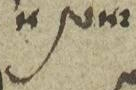

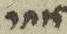

In [29]:
pair1 = Image(TRAIN_DIR+'/780_3.png')
pair2 = Image(TRAIN_DIR+'/697_1.png')
display(pair1,pair2)

In [30]:
print_map=custom_call()
training_generator = DataGenerator(hard_train_pair_names, batch_size=16, shuffle=True)

In [31]:
model.fit_generator(training_generator,
                    epochs=100,
                    callbacks=[print_map])

Epoch 1/100
test map: 0.58795935454
    2/21180 [..............................] - ETA: 21:28:59 - loss: 0.4993 - acc: 0.9688

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.772107). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.886608). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9810 map: 0.611543902101
best map= 0.611543902101
patient= 0
21180/21180 [==============================] - 2402s 113ms/step - loss: 0.0655 - acc: 0.9810
Epoch 2/100
test map: 0.611621518758
    3/21180 [..............................] - ETA: 11:22:05 - loss: 0.0102 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.505334). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.753092). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9923 map: 0.613817590692
best map= 0.613817590692
patient= 0
21180/21180 [==============================] - 2395s 113ms/step - loss: 0.0276 - acc: 0.9923
Epoch 3/100
test map: 0.613803180926
    2/21180 [..............................] - ETA: 17:24:16 - loss: 0.0150 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.718138). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.859839). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9947 map: 0.616074732861
best map= 0.616074732861
patient= 0
21180/21180 [==============================] - 2392s 113ms/step - loss: 0.0202 - acc: 0.9947
Epoch 4/100
test map: 0.616046742564
    3/21180 [..............................] - ETA: 11:58:56 - loss: 0.0140 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.813731). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.907497). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9957 map: 0.616953727261
best map= 0.616953727261
patient= 0
21180/21180 [==============================] - 2395s 113ms/step - loss: 0.0169 - acc: 0.9957
Epoch 5/100
test map: 0.617014558995
    2/21180 [..............................] - ETA: 16:48:32 - loss: 3.5265e-04 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.517450). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.759306). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9963 map: 0.618815292816
best map= 0.618815292816
patient= 0
21180/21180 [==============================] - 2398s 113ms/step - loss: 0.0147 - acc: 0.9963
Epoch 6/100
test map: 0.618832449676
    3/21180 [..............................] - ETA: 11:52:58 - loss: 0.0669 - acc: 0.9792

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.762065). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.881640). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9967 map: 0.61557608387
current map= 0.61557608387
best map= 0.618815292816
patient= 1
21180/21180 [==============================] - 2400s 113ms/step - loss: 0.0136 - acc: 0.9967
Epoch 7/100
test map: 0.615529201795
    3/21180 [..............................] - ETA: 11:49:45 - loss: 0.0092 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.737006). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.869152). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9968 map: 0.618638341737
current map= 0.618638341737
best map= 0.618815292816
patient= 2
21180/21180 [==============================] - 2394s 113ms/step - loss: 0.0132 - acc: 0.9968
Epoch 8/100
test map: 0.618745014472
    3/21180 [..............................] - ETA: 11:41:27 - loss: 0.0011 - acc: 1.0000    

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.673554). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.837283). Check your callbacks.
  % delta_t_median)


21179/21180 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9971 map: 0.617493634171
current map= 0.617493634171
best map= 0.618815292816
patient= 3
21180/21180 [==============================] - 2391s 113ms/step - loss: 0.0120 - acc: 0.9971
Epoch 9/100
test map: 0.61747941658
    3/21180 [..............................] - ETA: 11:33:34 - loss: 0.0023 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (5.598837). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.799986). Check your callbacks.
  % delta_t_median)


 9500/21180 [============>.................] - ETA: 21:53 - loss: 0.0104 - acc: 0.9976

KeyboardInterrupt: 

In [32]:
feat_extractor = Model(inputs=model.layers[2].get_input_at(0), outputs=model.layers[2].layers[19].output)
features=feat_extractor.predict(x_test)

In [33]:
map_from_feature_matrix(features, y_test, 'euclidean', True)[0]

0.61902132580466573

In [34]:
def save_first_n_retrievals(images, features, labels, metric, query_index, number_of_retrievals):
    # argument error checks
    if features.shape[0] != len(labels):
        raise ValueError('The number of feature vectors and number of labels must match')
    # compute the pairwise distances from the features
    dists = pdist(X=features, metric=metric)
    dists = squareform(dists)
    inds = np.argsort(dists, axis=1)
    label=labels[query_index]
    sorted_images=[images[i]*255 for i in inds[query_index][:number_of_retrievals]]
    if not os.path.exists('first_n_retrievals'):
        os.makedirs('first_n_retrievals')
    for i, img in enumerate(sorted_images):
        cv2.imwrite('first_n_retrievals/'+str(i)+'.png', img)
    return

In [35]:
save_first_n_retrievals(x_test, features, y_test, 'euclidean', 116, 5)